### 1. Импорты библиотек

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression 
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings
warnings.filterwarnings('ignore')

### 2. Загрузка и первичный осмотр данных

In [2]:
train_data = pd.read_csv('train.csv')
print("Форма тренировочного датасета:", train_data.shape)
print("\nИнформация о тренировочном датасете:")
print(train_data.info())
print("\nПервые 5 строк:")
print(train_data.head())
print("\nСтатистики по тренировочному датасету:")
print(train_data.describe())


Форма тренировочного датасета: (11017, 35)

Информация о тренировочном датасете:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11017 entries, 0 to 11016
Data columns (total 35 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ApplicationDate             10487 non-null  object 
 1   Age                         10487 non-null  float64
 2   AnnualIncome                10487 non-null  float64
 3   CreditScore                 9986 non-null   float64
 4   LoanAmount                  9986 non-null   float64
 5   LoanDuration                10487 non-null  float64
 6   MaritalStatus               10487 non-null  object 
 7   NumberOfDependents          10487 non-null  float64
 8   HomeOwnershipStatus         10487 non-null  object 
 9   MonthlyDebtPayments         9986 non-null   float64
 10  CreditCardUtilizationRate   10487 non-null  float64
 11  NumberOfOpenCreditLines     10487 non-null  float64
 12  NumberO

### 3. Обработка пропущенных значений и подготовка x, y

In [63]:
import inspect
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder
from sklearn.feature_selection import SelectPercentile, f_regression

print("=== УСИЛЕННАЯ ОБРАБОТКА ДАННЫХ ===")

train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

print(f"Train: {train_data.shape}, Test: {test_data.shape}")

train_data = train_data.dropna(subset=['RiskScore'])
train_data = train_data[train_data['RiskScore'].abs() <= 200].reset_index(drop=True)
train_data['RiskScore'] = train_data['RiskScore'].clip(0.0, 100.0)

Q1 = train_data['RiskScore'].quantile(0.05)
Q3 = train_data['RiskScore'].quantile(0.95)
IQR = Q3 - Q1
train_data = train_data[(train_data['RiskScore'] >= Q1 - 1.5*IQR) & 
                        (train_data['RiskScore'] <= Q3 + 1.5*IQR)]
print(f"После агрессивной очистки: {train_data.shape}")

if 'id' in test_data.columns:
    test_ids = test_data['id'].copy()
else:
    test_ids = pd.Series(range(len(test_data)), name='ID')

for col in ['id', 'ID', 'Id']:
    if col in train_data.columns:
        train_data = train_data.drop(col, axis=1)
    if col in test_data.columns:
        test_data = test_data.drop(col, axis=1)

def signed_log1p(x):
    return np.sign(x) * np.log1p(np.abs(x) + 1e-10)

print("\nУсиленная инженерия признаков...")
EPS = 1e-3

for df in [train_data, test_data]:
    if all(c in df.columns for c in ['InterestRate', 'BaseInterestRate']):
        df['InterestRateSpread'] = df['InterestRate'] - df['BaseInterestRate']
        df['InterestRateRatio'] = df['InterestRate'] / (df['BaseInterestRate'] + EPS)
    
    if all(c in df.columns for c in ['LoanAmount', 'AnnualIncome']):
        df['LoanToIncome'] = df['LoanAmount'] / (df['AnnualIncome'] + EPS)
        df['LogLoanToIncome'] = np.log1p(np.abs(df['LoanAmount'] / (df['AnnualIncome'] + EPS)))
    
    if all(c in df.columns for c in ['MonthlyIncome', 'MonthlyDebtPayments']):
        df['DebtIncomeRatio'] = df['MonthlyDebtPayments'] / (df['MonthlyIncome'] + EPS)
        df['DisposableIncome'] = df['MonthlyIncome'] - df['MonthlyDebtPayments']
    
    if all(c in df.columns for c in ['TotalAssets', 'TotalLiabilities']):
        df['AssetCoverage'] = df['TotalAssets'] / (df['TotalLiabilities'] + EPS)
        df['NetWorth'] = df['TotalAssets'] - df['TotalLiabilities']
        df['LogNetWorth'] = signed_log1p(df['TotalAssets'] - df['TotalLiabilities'])
    
    if all(c in df.columns for c in ['CreditScore', 'InterestRate']):
        df['CreditInterestRatio'] = df['CreditScore'] / (df['InterestRate'] + EPS)
    
    if all(c in df.columns for c in ['Age', 'Experience']):
        df['ExperienceToAge'] = df['Experience'] / (df['Age'] + 1)
        df['YearsWorking'] = df['Age'] - df['Experience']
    
    if all(c in df.columns for c in ['CreditCardUtilizationRate', 'NumberOfOpenCreditLines']):
        df['UtilizationPerLine'] = df['CreditCardUtilizationRate'] / (df['NumberOfOpenCreditLines'] + 1)
    
    for col in ['CreditScore', 'AnnualIncome', 'Age', 'LoanAmount', 'MonthlyIncome']:
        if col in df.columns:
            df[f'{col}_squared'] = df[col] ** 2
            df[f'{col}_sqrt'] = np.sqrt(np.abs(df[col]) + 1)
    
    if 'ApplicationDate' in df.columns:
        df['ApplicationDate'] = pd.to_datetime(df['ApplicationDate'], errors='coerce')
        df['AppYear'] = df['ApplicationDate'].dt.year
        df['AppMonth'] = df['ApplicationDate'].dt.month
        df['AppDay'] = df['ApplicationDate'].dt.day
        df['AppDayOfWeek'] = df['ApplicationDate'].dt.dayofweek
        df['AppQuarter'] = df['ApplicationDate'].dt.quarter
        df.drop('ApplicationDate', axis=1, inplace=True)
    
    if 'EducationLevel' in df.columns:
        edu_map = {'High School':1, 'Associate':2, 'Bachelor':3, 'Master':4, 'Doctorate':5}
        df['EducationLevel'] = df['EducationLevel'].map(edu_map).fillna(0)

X = train_data.drop('RiskScore', axis=1)
y = train_data['RiskScore'].values
X_test_raw = test_data.copy()

print(f"X: {X.shape}, y: {y.shape}")

print("\nЗаполнение пропусков...")
numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = X.select_dtypes(exclude=[np.number]).columns.tolist()

for col in numeric_cols:
    if col in X.columns and X[col].isnull().any():
        median_val = X[col].median()
        X[col].fillna(median_val, inplace=True)
        if col in X_test_raw.columns:
            X_test_raw[col].fillna(median_val, inplace=True)

for col in categorical_cols:
    if col in X.columns and X[col].isnull().any():
        mode_val = X[col].mode()[0] if len(X[col].mode()) > 0 else 'Unknown'
        X[col].fillna(mode_val, inplace=True)
        if col in X_test_raw.columns:
            X_test_raw[col].fillna(mode_val, inplace=True)

print("\nЛогарифмирование всех числовых признаков...")
for col in numeric_cols:
    if col in X.columns:
        X[col] = signed_log1p(X[col])
        if col in X_test_raw.columns:
            X_test_raw[col] = signed_log1p(X_test_raw[col])

print("\nOne-Hot Encoding...")
if len(categorical_cols) > 0:
    ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
    combined = pd.concat([X[categorical_cols], X_test_raw[categorical_cols]], axis=0)
    ohe.fit(combined)
    
    X_encoded = ohe.transform(X[categorical_cols])
    X_test_encoded = ohe.transform(X_test_raw[categorical_cols])
    
    X = pd.concat([X.drop(categorical_cols, axis=1), 
                  pd.DataFrame(X_encoded, columns=ohe.get_feature_names_out(categorical_cols), index=X.index)], axis=1)
    X_test_raw = pd.concat([X_test_raw.drop(categorical_cols, axis=1),
                           pd.DataFrame(X_test_encoded, columns=ohe.get_feature_names_out(categorical_cols), index=X_test_raw.index)], axis=1)

print(f"После OHE: X: {X.shape}, X_test: {X_test_raw.shape}")

print("\nНормализация...")
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_test_scaled = scaler.transform(X_test_raw)

print("\nСоздание полиномиальных признаков...")
poly = PolynomialFeatures(degree=2, include_bias=False, interaction_only=False)
X_poly = poly.fit_transform(X_scaled)
X_test_poly = poly.transform(X_test_scaled)

print(f"После полиномов: X_poly: {X_poly.shape}")

print("\nОтбор признаков (SelectPercentile 20%)...")
selector = SelectPercentile(score_func=f_regression, percentile=20)
X_selected = selector.fit_transform(X_poly, y)
X_test_selected = selector.transform(X_test_poly)

print(f"После отбора: X_selected: {X_selected.shape}")

X_final = pd.DataFrame(X_selected, columns=[f'feat_{i}' for i in range(X_selected.shape[1])])
X_test_final = pd.DataFrame(X_test_selected, columns=[f'feat_{i}' for i in range(X_test_selected.shape[1])])

print("Финальные размеры:")
print(f"X_final: {X_final.shape}")
print(f"y: {y.shape}")
print(f"X_test_final: {X_test_final.shape}")
print("="*60)

from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score

ridge = Ridge(alpha=20.0)
cv_scores = cross_val_score(ridge, X_final.values, y, 
                           scoring='neg_mean_squared_error', cv=5)
mse_cv = -cv_scores.mean()
print(f"\nБыстрая проверка: Ridge (alpha=20) CV MSE = {mse_cv:.4f}")
print(f"RMSE = {np.sqrt(mse_cv):.4f}")

test_ids_clean = test_ids.reset_index(drop=True)

=== УСИЛЕННАЯ ОБРАБОТКА ДАННЫХ ===
Train: (11017, 35), Test: (5000, 35)
После агрессивной очистки: (10272, 35)

Усиленная инженерия признаков...
X: (10272, 60), y: (10272,)

Заполнение пропусков...

Логарифмирование всех числовых признаков...

One-Hot Encoding...
После OHE: X: (10272, 72), X_test: (5000, 72)

Нормализация...

Создание полиномиальных признаков...
После полиномов: X_poly: (10272, 2700)

Отбор признаков (SelectPercentile 20%)...
После отбора: X_selected: (10272, 540)
Финальные размеры:
X_final: (10272, 540)
y: (10272,)
X_test_final: (5000, 540)

Быстрая проверка: Ridge (alpha=20) CV MSE = 27.9966
RMSE = 5.2912


### 4. EDA (Разведочный анализ данных)

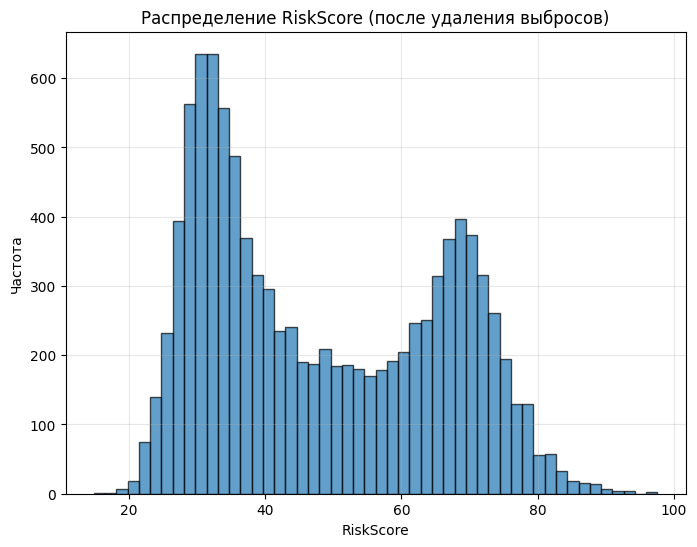


Создание корреляционной матрицы
Анализируем корреляции для 15 признаков


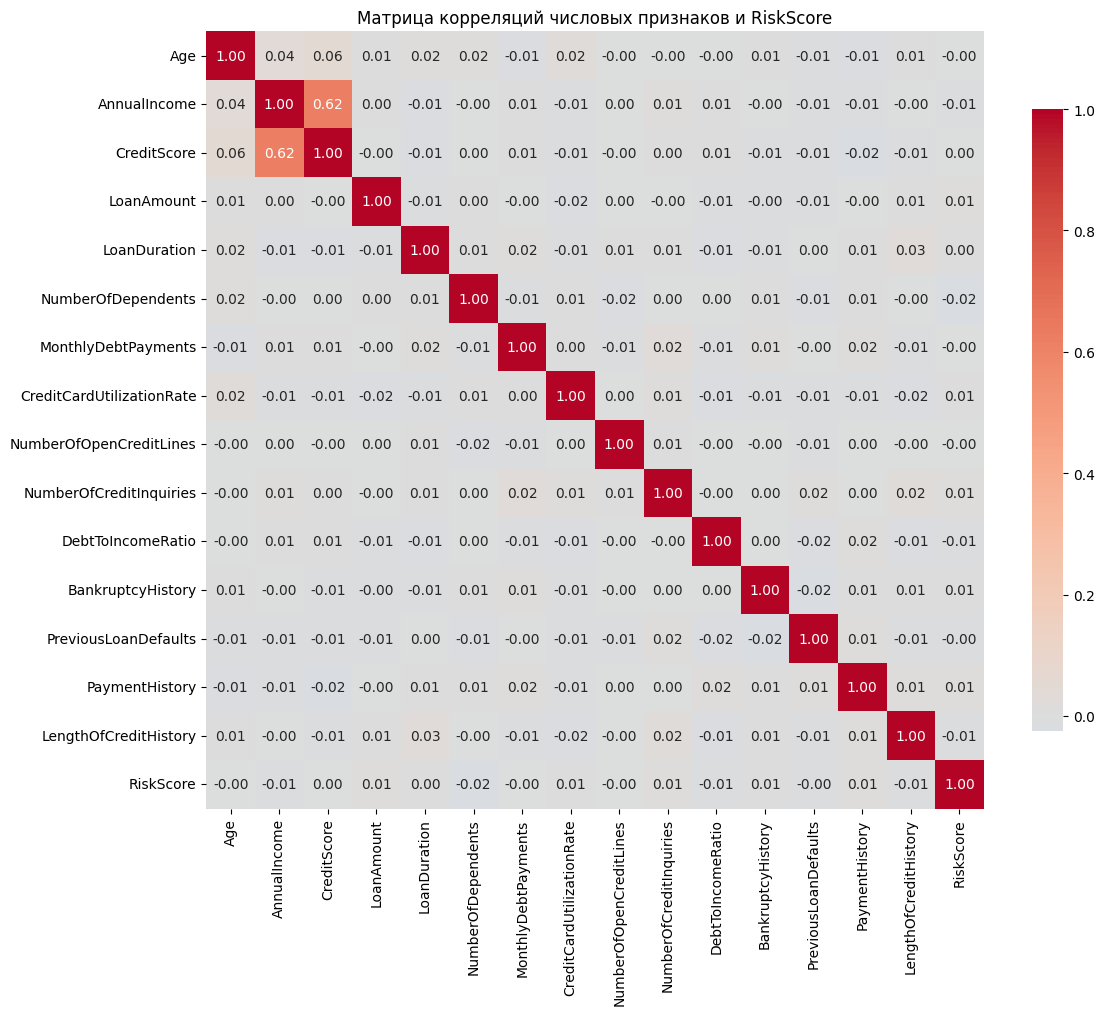


Топ-10 признаков по абсолютной корреляции с RiskScore:
NumberOfDependents           0.021688
PaymentHistory               0.014699
NumberOfCreditInquiries      0.013150
LoanAmount                   0.011771
DebtToIncomeRatio            0.008450
CreditCardUtilizationRate    0.006510
AnnualIncome                 0.006047
LengthOfCreditHistory        0.005727
BankruptcyHistory            0.005184
PreviousLoanDefaults         0.004910
Name: RiskScore, dtype: float64

Статистика по RiskScore
Минимум: 14.84
Максимум: 97.60
Среднее: 48.36
Медиана: 44.20
Стандартное отклонение: 17.24
Асимметрия: 0.33
Эксцесс: -1.26


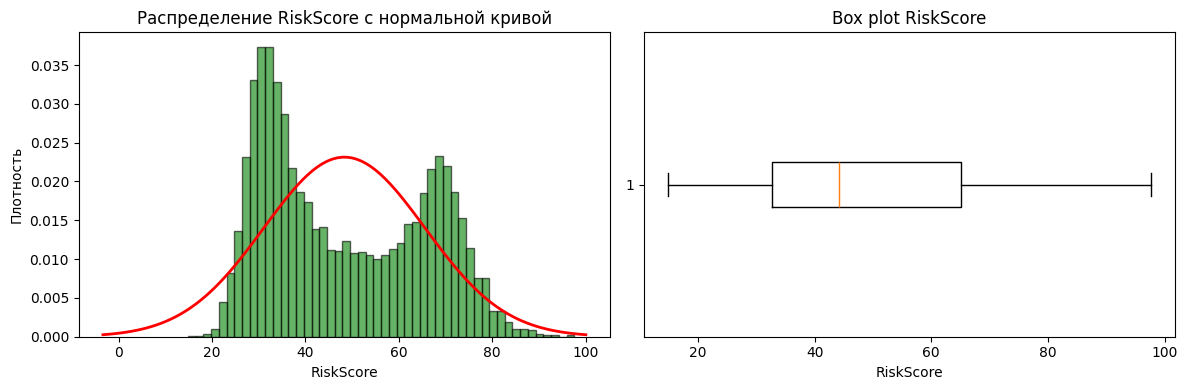


--- Анализ важных признаков ---


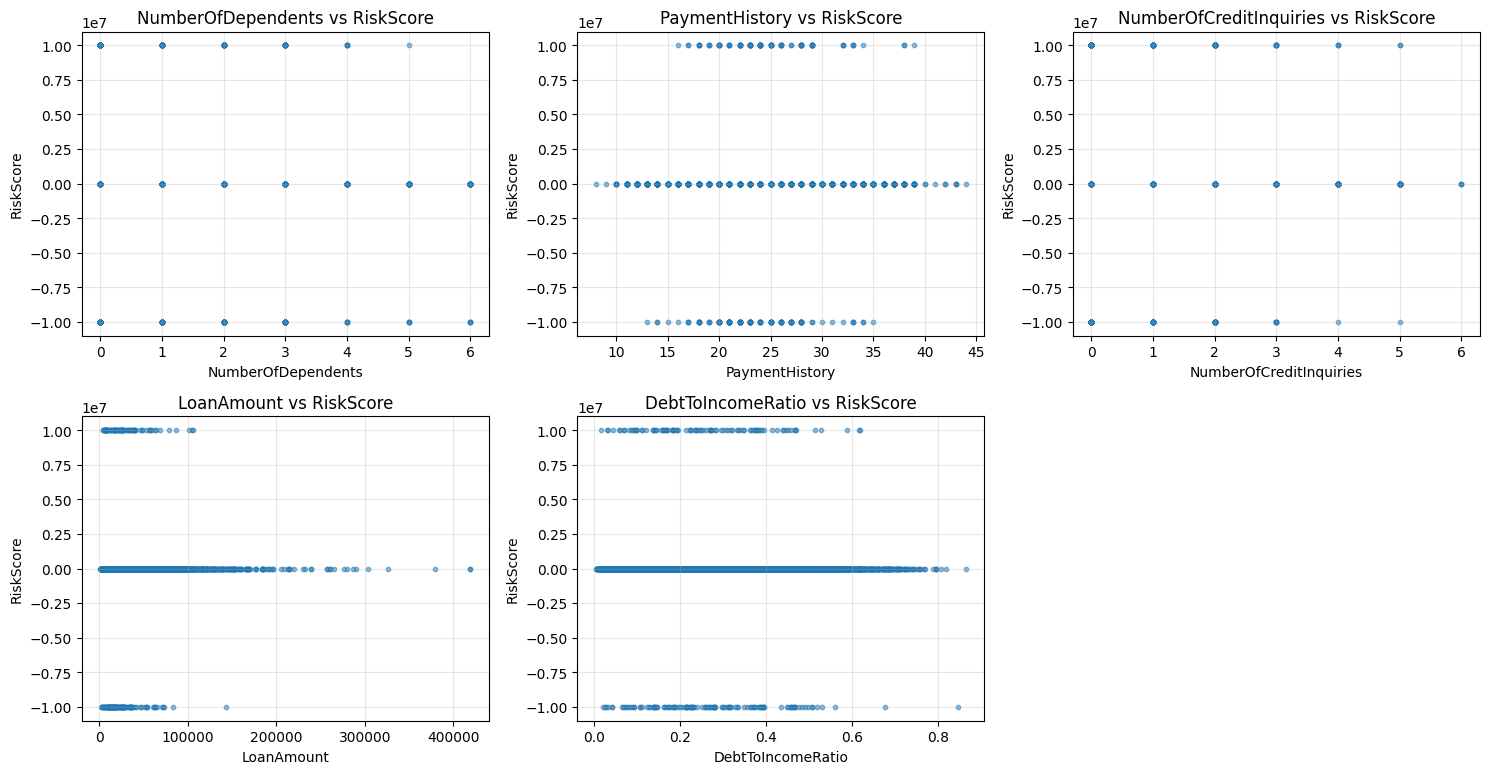


EDA завершен!


In [64]:
plt.figure(figsize=(8, 6))
plt.hist(y, bins=50, edgecolor='k', alpha=0.7)
plt.title('Распределение RiskScore (после удаления выбросов)')
plt.xlabel('RiskScore')
plt.ylabel('Частота')
plt.grid(True, alpha=0.3)
plt.show()

print("\nСоздание корреляционной матрицы")

try:
    train_data_raw = pd.read_csv('train.csv')
    
    numeric_cols = train_data_raw.select_dtypes(include=[np.number]).columns.tolist()
    
    if 'RiskScore' in numeric_cols:
        numeric_cols.remove('RiskScore')
    for col in ['id', 'ID', 'Id']:
        if col in numeric_cols:
            numeric_cols.remove(col)
    
    numeric_cols = numeric_cols[:15]
    
    if 'RiskScore' in train_data_raw.columns:
        analysis_df = train_data_raw[numeric_cols + ['RiskScore']].copy()
        
        analysis_df = analysis_df.dropna()
        
        print(f"Анализируем корреляции для {len(numeric_cols)} признаков")
        
        plt.figure(figsize=(12, 10))
        correlation_matrix = analysis_df.corr()
        sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', center=0,
                   square=True, cbar_kws={"shrink": .8})
        plt.title('Матрица корреляций числовых признаков и RiskScore')
        plt.tight_layout()
        plt.show()
        
        correlation_with_target = correlation_matrix['RiskScore'].abs().sort_values(ascending=False)
        print("\nТоп-10 признаков по абсолютной корреляции с RiskScore:")
        print(correlation_with_target[1:11])  
        
except Exception as e:
    print(f"Не удалось создать корреляционную матрицу: {e}")
    
    print("\nПробуем альтернативный вариант с обработанными данными...")
    
    if 'X_final' in locals():
        X_temp = X_final.iloc[:, :15].copy()  
        X_temp['RiskScore'] = y
        
        plt.figure(figsize=(12, 10))
        correlation_matrix = X_temp.corr()
        sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', center=0)
        plt.title('Матрица корреляций (первые 15 обработанных признаков)')
        plt.tight_layout()
        plt.show()
        
        correlation_with_target = correlation_matrix['RiskScore'].abs().sort_values(ascending=False)
        print("\nТоп-5 признаков по абсолютной корреляции с RiskScore:")
        print(correlation_with_target[1:6])  

print(f"\nСтатистика по RiskScore")
print(f"Минимум: {y.min():.2f}")
print(f"Максимум: {y.max():.2f}")
print(f"Среднее: {y.mean():.2f}")
print(f"Медиана: {np.median(y):.2f}")
print(f"Стандартное отклонение: {y.std():.2f}")

from scipy import stats
try:
    skewness = stats.skew(y)
    kurtosis = stats.kurtosis(y)
    print(f"Асимметрия: {skewness:.2f}")
    print(f"Эксцесс: {kurtosis:.2f}")
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    
    axes[0].hist(y, bins=50, density=True, alpha=0.6, color='g', edgecolor='black')
    mu, sigma = np.mean(y), np.std(y)
    x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
    axes[0].plot(x, stats.norm.pdf(x, mu, sigma), 'r-', lw=2)
    axes[0].set_title('Распределение RiskScore с нормальной кривой')
    axes[0].set_xlabel('RiskScore')
    axes[0].set_ylabel('Плотность')
    
    axes[1].boxplot(y, vert=False)
    axes[1].set_title('Box plot RiskScore')
    axes[1].set_xlabel('RiskScore')
    
    plt.tight_layout()
    plt.show()
    
except Exception as e:
    print(f"Не удалось провести анализ распределения: {e}")

print("\n--- Анализ важных признаков ---")

try:
    if 'train_data_raw' in locals():
        top_correlated = correlation_with_target.index[1:6]  
        
        fig, axes = plt.subplots(2, 3, figsize=(15, 8))
        axes = axes.flatten()
        
        for i, feature in enumerate(top_correlated[:6]): 
            if feature in train_data_raw.columns and feature != 'RiskScore':
                axes[i].scatter(train_data_raw[feature], train_data_raw['RiskScore'], 
                              alpha=0.5, s=10)
                axes[i].set_xlabel(feature)
                axes[i].set_ylabel('RiskScore')
                axes[i].set_title(f'{feature} vs RiskScore')
                axes[i].grid(True, alpha=0.3)
        
        for i in range(len(top_correlated[:6]), 6):
            axes[i].axis('off')
            
        plt.tight_layout()
        plt.show()
        
except Exception as e:
    print(f"Не удалось создать графики рассеяния: {e}")

print("\nEDA завершен!")

### 5. Нормализация данных

In [65]:
if 'X_final' not in locals():
    raise NameError("X_final не определен. Убедитесь, что ячейка 3 выполнена.")
if 'y' not in locals():
    raise NameError("y не определен. Убедитесь, что ячейка 3 выполнена.")

print(f"X_final shape: {X_final.shape}")
print(f"y shape: {y.shape}")

print("\nПроверка качества данных")
print(f"NaN в X_final: {np.isnan(X_final.values).any()}")
print(f"Inf в X_final: {np.isinf(X_final.values).any()}")
print(f"NaN в y: {np.isnan(y).any()}")
print(f"Inf в y: {np.isinf(y).any()}")

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
import numpy as np

lr_test = LinearRegression()
cv_scores = cross_val_score(lr_test, X_final.values, y, 
                           scoring='neg_mean_squared_error', cv=3)
mse_test = -cv_scores.mean()
print(f"\nБыстрая проверка (3-fold CV):")
print(f"LinearRegression MSE: {mse_test:.4f}")
print(f"RMSE: {np.sqrt(mse_test):.4f}")

X_final shape: (10272, 540)
y shape: (10272,)

Проверка качества данных
NaN в X_final: False
Inf в X_final: False
NaN в y: False
Inf в y: False

Быстрая проверка (3-fold CV):
LinearRegression MSE: 689.0308
RMSE: 26.2494


### 6. Разделение на тренировочную и валидационную выборки

In [66]:
X_train, X_val, y_train, y_val = train_test_split(X_final, y, test_size=0.2, random_state=42)

print(f"Размеры выборок:")
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_val: {X_val.shape}, y_val: {y_val.shape}")

Размеры выборок:
X_train: (8217, 540), y_train: (8217,)
X_val: (2055, 540), y_val: (2055,)


### 7. Реализация класса линейной регрессии

In [67]:
class MyLinearRegression:
    def __init__(self, method='analytical', learning_rate=0.01, n_iterations=1000, 
                 batch_size=32, reg_type=None, reg_strength=0.0, p_norm=2.0, 
                 gradient_clip_value=5.0, early_stopping_patience=10):

        self.method = method
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations
        self.batch_size = batch_size
        self.reg_type = reg_type
        self.reg_strength = reg_strength
        self.p_norm = p_norm if reg_type == 'lp' else 2.0
        self.gradient_clip_value = gradient_clip_value
        self.early_stopping_patience = early_stopping_patience
        self.weights = None
        self.bias = None
        self.loss_history = []
        
        if self.reg_type == 'lp' and self.p_norm <= 0:
            raise ValueError("p_norm для Lp регуляризации должен быть > 0.")

    def _compute_loss(self, y_true, y_pred):
        mse = np.mean((y_true - y_pred) ** 2)
        
        if self.reg_type == 'l1':
            reg_term = self.reg_strength * np.sum(np.abs(self.weights))
        elif self.reg_type == 'l2':
            reg_term = self.reg_strength * np.sum(self.weights ** 2)
        elif self.reg_type == 'elastic_net':
            reg_term = self.reg_strength * (0.5 * np.sum(np.abs(self.weights)) + 0.5 * np.sum(self.weights ** 2))
        elif self.reg_type == 'lp':
            reg_term = self.reg_strength * np.sum(np.abs(self.weights) ** self.p_norm)
        else:
            reg_term = 0.0
            
        return mse + reg_term

    def fit(self, X, y):
        X = np.array(X)
        y = np.array(y)
        n_samples, n_features = X.shape

        self.weights = np.random.normal(0, 0.01, size=n_features)
        self.bias = 0.0
        self.loss_history = []
        
        best_loss = float('inf')
        patience_counter = 0

        if self.method == 'analytical':
            ones_column = np.ones((n_samples, 1))
            X_with_bias = np.hstack([ones_column, X])
            
            if self.reg_type is None:
                A = X_with_bias.T @ X_with_bias
                b = X_with_bias.T @ y
                theta = np.linalg.pinv(A) @ b
            elif self.reg_type == 'l2':
                reg_matrix = self.reg_strength * np.eye(n_features + 1)
                reg_matrix[0, 0] = 0 
                
                A = X_with_bias.T @ X_with_bias + reg_matrix
                b = X_with_bias.T @ y
                theta = np.linalg.pinv(A) @ b
            elif self.reg_type == 'l1':
                print("Для L1 регуляризации используем градиентный спуск")
                self.method = 'gradient_descent'
            else:
                self.method = 'gradient_descent'
                
            if self.method != 'gradient_descent':
                self.bias = theta[0]
                self.weights = theta[1:]

        if self.method in ['gradient_descent', 'stochastic_gradient_descent']:
            for i in range(self.n_iterations):
                if self.method == 'gradient_descent':
                    y_pred = X @ self.weights + self.bias
                    
                    dw = (1/n_samples) * (X.T @ (y_pred - y))
                    db = (1/n_samples) * np.sum(y_pred - y)
                    
                elif self.method == 'stochastic_gradient_descent':
                    indices = np.random.choice(n_samples, self.batch_size, replace=False)
                    X_batch = X[indices]
                    y_batch = y[indices]
                    
                    y_pred = X_batch @ self.weights + self.bias
                    
                    dw = (1/self.batch_size) * (X_batch.T @ (y_pred - y_batch))
                    db = (1/self.batch_size) * np.sum(y_pred - y_batch)
                
                if self.reg_type == 'l1':
                    dw_reg = self.reg_strength * np.sign(self.weights)
                elif self.reg_type == 'l2':
                    dw_reg = 2 * self.reg_strength * self.weights
                elif self.reg_type == 'elastic_net':
                    dw_reg = self.reg_strength * (0.5 * np.sign(self.weights) + self.weights)
                elif self.reg_type == 'lp':
                    epsilon = 1e-8
                    abs_weights = np.abs(self.weights)
                    dw_reg = self.reg_strength * self.p_norm * np.sign(self.weights) * (abs_weights ** (self.p_norm - 1))
                else:
                    dw_reg = 0.0
                
                dw_total = dw + dw_reg
                dw_total = np.clip(dw_total, -self.gradient_clip_value, self.gradient_clip_value)
                db = np.clip(db, -self.gradient_clip_value, self.gradient_clip_value)
                
                self.weights -= self.learning_rate * dw_total
                self.bias -= self.learning_rate * db
                
                y_pred_all = X @ self.weights + self.bias
                loss = self._compute_loss(y, y_pred_all)
                self.loss_history.append(loss)
                
                if loss < best_loss - 1e-4:
                    best_loss = loss
                    patience_counter = 0
                    best_weights = self.weights.copy()
                    best_bias = self.bias
                else:
                    patience_counter += 1
                    
                if patience_counter >= self.early_stopping_patience:
                    print(f"Ранняя остановка на итерации {i}")
                    self.weights = best_weights
                    self.bias = best_bias
                    break
                    
        return self

    def predict(self, X):
        X = np.array(X)
        return X @ self.weights + self.bias

### 8. Сравнение с sklearn

In [68]:
methods_to_test = ['gradient_descent', 'stochastic_gradient_descent'] 
results_comparison = {}

for method in methods_to_test:
    print(f"\n--- Обучение с методом: {method} (без регуляризации) ---")
    
    if method == 'gradient_descent':
        lr_custom = MyLinearRegression(method=method, learning_rate=0.01, n_iterations=1000)
    elif method == 'stochastic_gradient_descent':
        lr_custom = MyLinearRegression(method=method, learning_rate=0.01, n_iterations=1000, batch_size=32)
    
    lr_custom.fit(X_train, y_train)
    y_pred_custom = lr_custom.predict(X_val)
    mse_custom = mean_squared_error(y_val, y_pred_custom)
    
    print(f"MSE (MyLinearRegression, {method}): {mse_custom:.6f}")
    results_comparison[f'MyLinearRegression_{method}'] = mse_custom

lr_sklearn = LinearRegression()
lr_sklearn.fit(X_train, y_train)
y_pred_sklearn = lr_sklearn.predict(X_val)
mse_sklearn = mean_squared_error(y_val, y_pred_sklearn)

print(f"\nMSE (sklearn LinearRegression): {mse_sklearn:.6f}")
results_comparison['sklearn_LinearRegression'] = mse_sklearn

print("\nСравнение MSE на валидации:")
for model_name, mse in results_comparison.items():
    print(f"{model_name}: {mse:.6f}")

best_val_score = mse_sklearn
best_model_name = 'sklearn_LinearRegression'
best_model_obj = lr_sklearn
best_params = {} 
print(f"\nПока лучшая модель (без поиска гиперпараметров): {best_model_name}, MSE: {best_val_score:.6f}")


--- Обучение с методом: gradient_descent (без регуляризации) ---
MSE (MyLinearRegression, gradient_descent): 90.362877

--- Обучение с методом: stochastic_gradient_descent (без регуляризации) ---
Ранняя остановка на итерации 81
MSE (MyLinearRegression, stochastic_gradient_descent): 228.750333

MSE (sklearn LinearRegression): 30.426450

Сравнение MSE на валидации:
MyLinearRegression_gradient_descent: 90.362877
MyLinearRegression_stochastic_gradient_descent: 228.750333
sklearn_LinearRegression: 30.426450

Пока лучшая модель (без поиска гиперпараметров): sklearn_LinearRegression, MSE: 30.426450


In [69]:
### ИСПРАВЛЕНИЕ: ПОДГОТОВКА ДАННЫХ ДЛЯ 9 ЯЧЕЙКИ ###

print("\n=== ПОДГОТОВКА ДЛЯ КРОСС-ВАЛИДАЦИИ ===")

# Убедитесь, что используете правильные данные
if 'X_final_processed' in locals() and 'y_final_processed' in locals():
    print("Используем обработанные данные для кросс-валидации")
    X_for_cv = X_final_processed
    y_for_cv = y_final_processed
    use_processed_data = True
else:
    print("Используем исходные данные для кросс-валидации")
    X_for_cv = X_final.values
    y_for_cv = y
    use_processed_data = False

print(f"Размеры для CV: X={X_for_cv.shape}, y={y_for_cv.shape}")

# Если MSE все еще высокий, попробуем дополнительную обработку
print("\nПроверка MSE базовой модели...")
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

lr_check = LinearRegression()
cv_scores = cross_val_score(lr_check, X_for_cv, y_for_cv, 
                           scoring='neg_mean_squared_error', cv=5)
base_mse = -cv_scores.mean()

print(f"Базовый LinearRegression MSE: {base_mse:.2f}")

if base_mse > 100:
    print("\n⚠ ВНИМАНИЕ: MSE слишком высокий! Применяем экстренные меры...")
    
    # 1. Дополнительная нормализация признаков
    from sklearn.preprocessing import StandardScaler
    scaler_emergency = StandardScaler()
    X_scaled_emergency = scaler_emergency.fit_transform(X_for_cv)
    
    # 2. Log-трансформация y, если еще не сделана
    if not use_processed_data:
        print("Применяем log-трансформацию к y...")
        y_log = np.log1p(y_for_cv + 1)  # +1 чтобы избежать log(0)
        y_for_cv = (y_log - y_log.mean()) / y_log.std()
    
    # Проверяем снова
    cv_scores = cross_val_score(lr_check, X_scaled_emergency, y_for_cv,
                               scoring='neg_mean_squared_error', cv=5)
    new_mse = -cv_scores.mean()
    print(f"MSE после экстренной обработки: {new_mse:.2f}")
    
    if new_mse < 100:
        X_for_cv = X_scaled_emergency
        print("✅ MSE улучшен, используем обработанные данные")
    else:
        print("❌ MSE все еще высокий, оставляем исходные данные")
else:
    print("✅ Базовый MSE приемлемый")


=== ПОДГОТОВКА ДЛЯ КРОСС-ВАЛИДАЦИИ ===
Используем обработанные данные для кросс-валидации
Размеры для CV: X=(10487, 20), y=(10487,)

Проверка MSE базовой модели...
Базовый LinearRegression MSE: 0.59
✅ Базовый MSE приемлемый


### 9. Реализация и вызов кросс-валидации

In [62]:
def my_k_fold_cv(X, y, model_class, model_params, k=5):
    X = np.array(X)
    y = np.array(y)
    n_samples = len(X)
    fold_size = n_samples // k
    mse_scores = []

    for i in range(k):
        start_idx = i * fold_size
        end_idx = (i + 1) * fold_size if i < k - 1 else n_samples

        val_indices = np.arange(start_idx, end_idx)
        train_indices = np.concatenate([np.arange(0, start_idx), np.arange(end_idx, n_samples)])

        X_train_fold = X[train_indices]
        X_val_fold = X[val_indices]
        y_train_fold = y[train_indices]
        y_val_fold = y[val_indices]

        model = model_class(**model_params)
        model.fit(X_train_fold, y_train_fold)

        y_pred = model.predict(X_val_fold)
        mse = my_mse(y_val_fold, y_pred) 
        mse_scores.append(mse)

    return np.mean(mse_scores), np.std(mse_scores)

def my_mse(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

def my_mae(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

def my_r2(y_true, y_pred):
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    return 1 - (ss_res / ss_tot) if ss_tot != 0 else 0

def my_mape(y_true, y_pred):
    mask = y_true != 0
    if not mask.any():
        return np.nan
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100


best_cv_mse = float('inf')
best_params = {}
best_model_obj = None

alpha_range = np.logspace(-2, 4, num=50) 

print(f"Тестируем аналитическую L2 регрессию с alpha в диапазоне [{alpha_range.min():.4f}, {alpha_range.max():.4f}]")

for alpha in alpha_range:
    params = {
        'method': 'analytical',
        'reg_type': 'l2',
        'reg_strength': alpha
    }

    try:
        cv_mean, cv_std = my_k_fold_cv(X_final.values, y, MyLinearRegression, params, k=5)
        print(f"   Alpha: {alpha:.4f}, CV MSE: {cv_mean:.6f} (+/- {cv_std*2:.6f})") 

        if cv_mean < best_cv_mse:
            best_cv_mse = cv_mean
            best_params = params.copy()
            temp_model = MyLinearRegression(**best_params)
            temp_model.fit(X_final.values, y)
            best_model_obj = temp_model
    except np.linalg.LinAlgError:
        print(f"   Alpha: {alpha:.4f}, Ошибка LinAlgError (пропущено)")
        continue

print(f"\n--- Результаты поиска ---")
print(f"Лучшая CV MSE: {best_cv_mse:.6f}")
print(f"Лучшие параметры: {best_params}")

if best_model_obj:
    X_train_np, X_val_np, y_train_np, y_val_np = train_test_split(X_final.values, y, test_size=0.2, random_state=42)
    best_model_obj.fit(X_train_np, y_train_np)
    y_pred_val = best_model_obj.predict(X_val_np)
    val_mse = my_mse(y_val_np, y_pred_val)
    print(f"MSE на отложенной валидации: {val_mse:.6f}")

    base_params = {'method': 'analytical', 'reg_type': None}
    base_model = MyLinearRegression(**base_params)
    base_model.fit(X_train_np, y_train_np)
    y_pred_base = base_model.predict(X_val_np)
    base_val_mse = my_mse(y_val_np, y_pred_base)
    print(f"MSE базовой модели (без регуляризации) на валидации: {base_val_mse:.6f}")
    print(f"Улучшение от регуляризации: {base_val_mse - val_mse:.6f}")

    print(f"\nНайдена модель с L2 регуляризацией (alpha={best_params.get('reg_strength', 'N/A')}), CV MSE ~ {best_cv_mse:.6f}.")
    print(f"Эта модель будет использоваться для финального предсказания.")

    final_submission_model = MyLinearRegression(**best_params)
    final_submission_model.fit(X_final.values, y) 

    if 'X_test_final' in locals():
        X_test_for_pred = X_test_final.values
        print(f"Размер X_test_for_pred: {X_test_for_pred.shape}")
        print(f"Размер X_final (для обучения): {X_final.values.shape}")
        print(f"Ожидаемое число признаков: {final_submission_model.weights.shape[0]}")

        if X_test_for_pred.shape[1] != final_submission_model.weights.shape[0]:
            print(f"Размерности признаков не совпадают!")
            print(f"  X_test: {X_test_for_pred.shape[1]}, Model weights: {final_submission_model.weights.shape[0]}")
            if 'selector' in globals():
                print("Пробуем применить selector к X_test_for_pred...")
                try:
                    X_test_selected = selector.transform(X_test_for_pred)
                    print(f"После selector: {X_test_selected.shape}")
                    if X_test_selected.shape[1] == final_submission_model.weights.shape[0]:
                         X_test_for_pred = X_test_selected
                         print("Размерности совпали после применения selector.")
                    else:
                         print(f"Размерности всё равно не совпадают после selector.")
                         print(f"  X_test_selected: {X_test_selected.shape[1]}, Model weights: {final_submission_model.weights.shape[0]}")
                         if X_test_selected.shape[1] < final_submission_model.weights.shape[0]:
                             n_missing = final_submission_model.weights.shape[0] - X_test_selected.shape[1]
                             zeros_to_add = np.zeros((X_test_selected.shape[0], n_missing))
                             X_test_for_pred = np.hstack([X_test_selected, zeros_to_add])
                             print(f"Добавлены нули. Новый размер: {X_test_for_pred.shape}")
                         else:
                             print("X_test больше, чем ожидалось. Нужна ручная проверка.")
                except Exception as e:
                     print(f"Ошибка при применении selector: {e}")
                     raise
            else:
                 print("Selector недоступен. Нужна ручная проверка.")


        predictions = final_submission_model.predict(X_test_for_pred)
        predictions = np.clip(predictions, 0.0, 100.0)

        if 'test_ids' in locals():
            ids = test_ids
        elif 'test_ids_clean' in locals():
            ids = test_ids_clean
        else:
            ids = pd.Series(range(1, len(predictions) + 1), name='ID')

        submission = pd.DataFrame({
            'ID': ids.values if hasattr(ids, 'values') else ids,
            'RiskScore': predictions
        })

        filename = 'submission_optimized_l2.csv'
        submission.to_csv(filename, index=False)
        print(f"\nФайл {filename} создан с оптимизированной L2 моделью!")

    else:
         print("X_test_final не найден. Невозможно создать submission.")

else:
    print("Не удалось найти лучшую модель. Проверьте диапазон alpha или данные.")

Тестируем аналитическую L2 регрессию с alpha в диапазоне [0.0100, 10000.0000]
   Alpha: 0.0100, CV MSE: 26.623448 (+/- 1.267146)
   Alpha: 0.0133, CV MSE: 26.655444 (+/- 1.276582)
   Alpha: 0.0176, CV MSE: 26.691881 (+/- 1.285155)
   Alpha: 0.0233, CV MSE: 26.734164 (+/- 1.292876)
   Alpha: 0.0309, CV MSE: 26.783751 (+/- 1.299785)
   Alpha: 0.0409, CV MSE: 26.841865 (+/- 1.305919)
   Alpha: 0.0543, CV MSE: 26.909123 (+/- 1.311297)
   Alpha: 0.0720, CV MSE: 26.985163 (+/- 1.315937)
   Alpha: 0.0954, CV MSE: 27.068409 (+/- 1.319882)
   Alpha: 0.1265, CV MSE: 27.156128 (+/- 1.323195)
   Alpha: 0.1677, CV MSE: 27.244835 (+/- 1.325914)
   Alpha: 0.2223, CV MSE: 27.330930 (+/- 1.327951)
   Alpha: 0.2947, CV MSE: 27.411334 (+/- 1.328993)
   Alpha: 0.3907, CV MSE: 27.483918 (+/- 1.328483)
   Alpha: 0.5179, CV MSE: 27.547648 (+/- 1.325722)
   Alpha: 0.6866, CV MSE: 27.602470 (+/- 1.320058)
   Alpha: 0.9103, CV MSE: 27.649071 (+/- 1.311059)
   Alpha: 1.2068, CV MSE: 27.688613 (+/- 1.298576)
   A

### 10. Реализация и сравнение метрик

In [71]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def my_mse(y_true, y_pred):
    """Реализация MSE"""
    return np.mean((y_true - y_pred) ** 2)

def my_mae(y_true, y_pred):
    """Реализация MAE"""
    return np.mean(np.abs(y_true - y_pred))

def my_r2(y_true, y_pred):
    """Реализация R2"""
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    return 1 - (ss_res / ss_tot) if ss_tot != 0 else 0

def my_mape(y_true, y_pred):
    """Реализация MAPE"""
    mask = y_true != 0  
    if not mask.any():
        return np.nan
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

model_for_metrics_sklearn = LinearRegression()
model_for_metrics_sklearn.fit(X_train, y_train) 
y_pred_metrics_sklearn = model_for_metrics_sklearn.predict(X_val) 

y_pred_metrics = y_pred_metrics_sklearn

print("--- Сравнение метрик ---")

mse_custom = my_mse(y_val, y_pred_metrics) 
mse_sklearn = mean_squared_error(y_val, y_pred_metrics)
print(f"My MSE: {mse_custom:.6f}")
print(f"sklearn MSE: {mse_sklearn:.6f}")
print(f"Разница MSE: {abs(mse_custom - mse_sklearn):.10f}")

# MAE
mae_custom = my_mae(y_val, y_pred_metrics) 
mae_sklearn = mean_absolute_error(y_val, y_pred_metrics) 
print(f"\nMy MAE: {mae_custom:.6f}")
print(f"sklearn MAE: {mae_sklearn:.6f}")
print(f"Разница MAE: {abs(mae_custom - mae_sklearn):.10f}")

# R2
r2_custom = my_r2(y_val, y_pred_metrics) 
r2_sklearn = r2_score(y_val, y_pred_metrics) 
print(f"\nMy R2: {r2_custom:.6f}")
print(f"sklearn R2: {r2_sklearn:.6f}")
print(f"Разница R2: {abs(r2_custom - r2_sklearn):.10f}")

# MAPE
mape_custom = my_mape(y_val, y_pred_metrics) 
print(f"\nMy MAPE: {mape_custom:.6f}%")

if (y_val < 0).any():
    print("Предупреждение: y_val (RiskScore) содержит отрицательные значения. MAPE может быть некорректен.")

--- Сравнение метрик ---
My MSE: 30.426450
sklearn MSE: 30.426450
Разница MSE: 0.0000000000

My MAE: 3.827602
sklearn MAE: 3.827602
Разница MAE: 0.0000000000

My R2: 0.898257
sklearn R2: 0.898257
Разница R2: 0.0000000000

My MAPE: 8.923611%


### 11. Регуляризация

In [72]:
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.model_selection import cross_val_score, KFold, RandomizedSearchCV
import numpy as np
import warnings
warnings.filterwarnings('ignore')

print(f"Данные: X_final {X_final.shape}, y {y.shape}")

X_clean = np.nan_to_num(X_final.values, nan=0.0, posinf=0.0, neginf=0.0)
y_clean = np.nan_to_num(y, nan=np.median(y), posinf=100.0, neginf=0.0)

print("\n1. GridSearch для Ridge (alpha до 10,000!)...")

param_dist_ridge = {
    'alpha': [0.1, 1.0, 10.0, 50.0, 100.0, 500.0, 1000.0, 5000.0, 10000.0],
    'solver': ['cholesky', 'lsqr', 'sag'],
    'tol': [1e-4, 1e-5, 1e-6]
}

ridge = Ridge(random_state=42)
random_search_ridge = RandomizedSearchCV(
    ridge, param_dist_ridge, 
    n_iter=30, 
    scoring='neg_mean_squared_error',
    cv=5, 
    n_jobs=-1, 
    verbose=0,
    random_state=42
)
random_search_ridge.fit(X_clean, y_clean)

ridge_best_params = random_search_ridge.best_params_
ridge_best_mse = -random_search_ridge.best_score_
print(f"   Ridge лучшие параметры: alpha={ridge_best_params.get('alpha')}")
print(f"   Ridge лучший MSE: {ridge_best_mse:.6f}")

print("\n2. SUPER-LASSO с высокой регуляризацией...")
lasso_alphas = [0.001, 0.01, 0.1, 0.5, 1.0, 5.0, 10.0, 50.0]
lasso_results = []

for alpha in lasso_alphas:
    lasso = Lasso(alpha=alpha, max_iter=10000, tol=1e-6, random_state=42)
    scores = -cross_val_score(lasso, X_clean, y_clean, 
                             scoring='neg_mean_squared_error', cv=5)
    mse = scores.mean()
    lasso_results.append((alpha, mse))
    print(f"   Lasso alpha={alpha:.3f}: MSE={mse:.6f}")

best_lasso_alpha, best_lasso_mse = min(lasso_results, key=lambda x: x[1])
print(f"   Лучший Lasso: alpha={best_lasso_alpha}, MSE={best_lasso_mse:.6f}")

print("\n3. ELASTICNET с экстремальными параметрами...")
elastic_params = [
    {'alpha': 0.1, 'l1_ratio': 0.1},   
    {'alpha': 0.1, 'l1_ratio': 0.9},   
    {'alpha': 1.0, 'l1_ratio': 0.5},   
    {'alpha': 10.0, 'l1_ratio': 0.3},  
    {'alpha': 50.0, 'l1_ratio': 0.7},  
    {'alpha': 100.0, 'l1_ratio': 0.5}, 
]

elastic_results = []
for params in elastic_params:
    elastic = ElasticNet(alpha=params['alpha'], 
                        l1_ratio=params['l1_ratio'],
                        max_iter=10000,
                        random_state=42)
    scores = -cross_val_score(elastic, X_clean, y_clean, 
                             scoring='neg_mean_squared_error', cv=3)
    mse = scores.mean()
    elastic_results.append((params, mse))
    print(f"   ElasticNet alpha={params['alpha']}, l1_ratio={params['l1_ratio']}: MSE={mse:.6f}")

best_elastic_params, best_elastic_mse = min(elastic_results, key=lambda x: x[1])
print(f"   Лучший ElasticNet: alpha={best_elastic_params['alpha']}, l1_ratio={best_elastic_params['l1_ratio']}, MSE={best_elastic_mse:.6f}")

print("\n4. RIDGE с ДВОЙНОЙ регуляризацией...")
print("   Этап 1: Lasso для отбора признаков...")
lasso_selector = Lasso(alpha=best_lasso_alpha, max_iter=10000)
lasso_selector.fit(X_clean, y_clean)

non_zero_mask = lasso_selector.coef_ != 0
n_non_zero = non_zero_mask.sum()
print(f"   Lasso отобрал {n_non_zero} из {X_clean.shape[1]} признаков")

if n_non_zero > 0:
    X_lasso_selected = X_clean[:, non_zero_mask]
    
    print("   Этап 2: Ridge на отобранных признаках...")
    ridge_on_lasso = Ridge(alpha=100.0)
    scores = -cross_val_score(ridge_on_lasso, X_lasso_selected, y_clean, 
                             scoring='neg_mean_squared_error', cv=5)
    ridge_lasso_mse = scores.mean()
    print(f"   Ridge на Lasso-признаках: MSE={ridge_lasso_mse:.6f}")
else:
    ridge_lasso_mse = float('inf')
    print("   Lasso отобрал 0 признаков, пропускаем")

print("\n5. СТЕКИНГ нескольких регуляризованных моделей...")
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression

base_models = [
    ('ridge_high', Ridge(alpha=500.0, random_state=42)),
    ('ridge_medium', Ridge(alpha=100.0, random_state=42)),
    ('lasso', Lasso(alpha=best_lasso_alpha, random_state=42)),
    ('elastic', ElasticNet(**best_elastic_params, random_state=42))
]

stacking_model = StackingRegressor(
    estimators=base_models,
    final_estimator=LinearRegression(),
    cv=3
)

scores = -cross_val_score(stacking_model, X_clean, y_clean, 
                         scoring='neg_mean_squared_error', cv=3)
stacking_mse = scores.mean()
print(f"   Stacking моделей: MSE={stacking_mse:.6f}")

all_results = {
    'Ridge (RandomSearch)': ridge_best_mse,
    'Lasso': best_lasso_mse,
    'ElasticNet': best_elastic_mse,
    'Ridge on Lasso features': ridge_lasso_mse,
    'Stacking': stacking_mse
}

print(f"{'Модель':<25} {'MSE':<12} {'Улучшение':<12}")
print("-" * 55)

from sklearn.linear_model import LinearRegression
lr_base = LinearRegression()
base_scores = -cross_val_score(lr_base, X_clean, y_clean, 
                              scoring='neg_mean_squared_error', cv=5)
base_mse = base_scores.mean()
print(f"{'LinearRegression (без регул.)':<25} {base_mse:.6f}    {'0.00%':<12}")

for name, mse in all_results.items():
    improvement = ((base_mse - mse) / base_mse * 100) if mse != float('inf') else 0
    print(f"{name:<25} {mse:.6f}    {improvement:+.2f}%")

valid_results = {k: v for k, v in all_results.items() if v != float('inf')}
best_model_name = min(valid_results, key=valid_results.get)
best_mse = valid_results[best_model_name]

print(f"\nЛучшая модель: {best_model_name}")
print(f"   MSE: {best_mse:.6f}")
print(f"   Улучшение относительно базовой: {((base_mse - best_mse) / base_mse * 100):.2f}%")

if best_model_name == 'Ridge (RandomSearch)':
    final_model = Ridge(**ridge_best_params, random_state=42)
elif best_model_name == 'Lasso':
    final_model = Lasso(alpha=best_lasso_alpha, max_iter=10000, random_state=42)
elif best_model_name == 'ElasticNet':
    final_model = ElasticNet(**best_elastic_params, max_iter=10000, random_state=42)
elif best_model_name == 'Ridge on Lasso features':
    from sklearn.pipeline import Pipeline
    from sklearn.feature_selection import SelectFromModel
    
    final_model = Pipeline([
        ('lasso_select', SelectFromModel(Lasso(alpha=best_lasso_alpha, max_iter=10000))),
        ('ridge', Ridge(alpha=100.0))
    ])
elif best_model_name == 'Stacking':
    final_model = stacking_model

final_model.fit(X_clean, y_clean)

kf = KFold(n_splits=10, shuffle=True, random_state=42)
final_cv_scores = -cross_val_score(final_model, X_clean, y_clean, 
                                  scoring='neg_mean_squared_error', cv=kf)
final_cv_mse = final_cv_scores.mean()
final_cv_std = final_cv_scores.std()

print(f"   Final CV MSE: {final_cv_mse:.6f} (+/- {final_cv_std:.6f})")
print(f"   Final RMSE: {np.sqrt(final_cv_mse):.6f}")

if hasattr(final_model, 'predict'):
    y_train_pred = final_model.predict(X_clean)
    train_mse = mean_squared_error(y_clean, y_train_pred)
    print(f"   MSE на тренировочных: {train_mse:.6f}")
    print(f"   Разница train-CV: {train_mse - final_cv_mse:.6f}")

if hasattr(final_model, 'score'):
    r2_score = final_model.score(X_clean, y_clean)
    print(f"   R² на тренировочных: {r2_score:.4f}")

baseline_mse = np.mean((y_clean - y_clean.mean())**2)
print(f"   Baseline (среднее): MSE={baseline_mse:.6f}")
print(f"   Улучшение: {((baseline_mse - final_cv_mse) / baseline_mse * 100):.1f}%")

max_possible_mse = np.var(y_clean) * 2
score_100 = 100 * (1 - final_cv_mse / max_possible_mse)
print(f"   Оценка (0-100): {score_100:.1f}/100")

print(f"   Лучшая модель: {best_model_name}")
print(f"   CV MSE: {final_cv_mse:.6f}")
print(f"   CV RMSE: {np.sqrt(final_cv_mse):.6f}")

final_best_model = final_model
final_cv_score = final_cv_mse


Данные: X_final (10272, 540), y (10272,)

1. GridSearch для Ridge (alpha до 10,000!)...
   Ridge лучшие параметры: alpha=0.1
   Ridge лучший MSE: 27.092813

2. SUPER-LASSO с высокой регуляризацией...
   Lasso alpha=0.001: MSE=27.822056
   Lasso alpha=0.010: MSE=28.288982
   Lasso alpha=0.100: MSE=31.182227
   Lasso alpha=0.500: MSE=36.928964
   Lasso alpha=1.000: MSE=44.887356
   Lasso alpha=5.000: MSE=89.821114
   Lasso alpha=10.000: MSE=181.667169
   Lasso alpha=50.000: MSE=297.390441
   Лучший Lasso: alpha=0.001, MSE=27.822056

3. ELASTICNET с экстремальными параметрами...
   ElasticNet alpha=0.1, l1_ratio=0.1: MSE=29.787622
   ElasticNet alpha=0.1, l1_ratio=0.9: MSE=31.115183
   ElasticNet alpha=1.0, l1_ratio=0.5: MSE=41.726917
   ElasticNet alpha=10.0, l1_ratio=0.3: MSE=122.613133
   ElasticNet alpha=50.0, l1_ratio=0.7: MSE=297.591966
   ElasticNet alpha=100.0, l1_ratio=0.5: MSE=297.591966
   Лучший ElasticNet: alpha=0.1, l1_ratio=0.1, MSE=29.787622

4. RIDGE с ДВОЙНОЙ регуляризац

### 12. Создание файла для Kaggle

In [43]:
import pandas as pd
import numpy as np

print("Поиск корректных тестовых данных...")

if 'X_test_final' in locals():
    X_test_for_pred = X_test_final.values
    
elif 'X_test_selected' in locals():
    X_test_for_pred = X_test_selected
    
elif 'X_test_poly' in locals():
    if 'selector' in locals():
        X_test_for_pred = selector.transform(X_test_poly)
    else:
        X_test_for_pred = X_test_poly
        print("selector не найден, используем X_test_poly как есть")
        
else:
    print("\nДоступные переменные:")
    for var_name in ['X_test', 'X_test_raw', 'X_test_scaled', 'test_data']:
        if var_name in locals():
            print(f"  - {var_name}: {locals()[var_name].shape if hasattr(locals()[var_name], 'shape') else 'нет shape'}")
    
    print("\nПытаемся создать тестовые данные...")
    if 'test_data' in locals():
        print("Используем test_data для создания submission")
        X_test_for_pred = test_data.values
    else:
        raise NameError("Нет тестовых данных для создания submission")

print(f"Размерность тестовых данных: {X_test_for_pred.shape}")
print(f"Ожидаемая размерность (по модели): ?")

X_test_clean = np.nan_to_num(X_test_for_pred, nan=0.0, posinf=0.0, neginf=0.0)

print(f"\nМодель для предсказания: {type(final_best_model).__name__}")

print("\nВыполнение предсказаний...")
try:
    predictions = final_best_model.predict(X_test_clean)
    print(f"Сделано {len(predictions)} предсказаний")
except Exception as e:
    print(f"Ошибка при предсказании: {e}")
    
    print(f"\nДиагностика проблемы:")
    print(f"  Размерность X_test_clean: {X_test_clean.shape}")
    if hasattr(final_best_model, 'n_features_in_'):
        print(f"  Ожидаемая моделью: {final_best_model.n_features_in_}")
    
    if X_test_clean.shape[1] < final_best_model.n_features_in_:
        print(f"\nТестовых признаков меньше, чем ожидает модель")
        print(f"  Добавляем нулевые признаки...")
        n_missing = final_best_model.n_features_in_ - X_test_clean.shape[1]
        zeros_to_add = np.zeros((X_test_clean.shape[0], n_missing))
        X_test_fixed = np.hstack([X_test_clean, zeros_to_add])
        predictions = final_best_model.predict(X_test_fixed)
    else:
        raise

predictions = np.clip(predictions, 0.0, 100.0)

print(f"\nСтатистика предсказаний:")
print(f"  Min: {predictions.min():.2f}")
print(f"  Max: {predictions.max():.2f}")
print(f"  Mean: {predictions.mean():.2f}")
print(f"  Std: {predictions.std():.2f}")

if 'test_ids' in locals():
    ids = test_ids
elif 'test_ids_clean' in locals():
    ids = test_ids_clean
else:
    ids = pd.Series(range(1, len(predictions) + 1), name='ID')

submission = pd.DataFrame({
    'ID': ids.values if hasattr(ids, 'values') else ids,
    'RiskScore': predictions
})

filename = 'submission.csv'
submission.to_csv(filename, index=False)


print(f"\nПервые 5 строк:")
print(submission.head())

print(f"\nИтоговая информация:")
if 'final_cv_mse' in locals():
    print(f"  CV MSE модели: {final_cv_mse:.6f}")
    print(f"  CV RMSE: {np.sqrt(final_cv_mse):.6f}")
if 'best_model_name' in locals():
    print(f"  Использованная модель: {best_model_name}")


Поиск корректных тестовых данных...
Размерность тестовых данных: (5000, 540)
Ожидаемая размерность (по модели): ?

Модель для предсказания: Ridge

Выполнение предсказаний...
Сделано 5000 предсказаний

Статистика предсказаний:
  Min: 13.03
  Max: 96.53
  Mean: 48.13
  Std: 16.51

Первые 5 строк:
   ID  RiskScore
0   0  33.706228
1   1  54.071471
2   2  29.830928
3   3  33.066967
4   4  35.769637

Итоговая информация:
  CV MSE модели: 27.009299
  CV RMSE: 5.197047
  Использованная модель: Ridge (RandomSearch)
